### 令和6年6月25日(火)
TODO:FLAGの掛け合わせで特徴量作成

#### 1. 読み込み

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors , KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
# LGBMClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from hyperopt import hp, fmin, tpe, Trials
import warnings

import sys
sys.path.append('../')
from my_utils import MyUtils
warnings.filterwarnings('ignore')

In [2]:
INPUT_DIR = "../input/"
output_path = "C:/Users/gwsgs/workSpace/GCIcomp2/02.（公開）コンペ2/output/"
exel_path = 'score_record.xlsx'     

In [3]:
utils = MyUtils(input_path=INPUT_DIR, output_path=output_path, exel_path=exel_path)
train, test, X_train, y_train, sample_sub = utils.load_data()
params = utils.params
output_path = utils.get_output_path

#### 2. 前処理と特徴量作成

In [4]:
# 欠損値のラベルカウントエンコーディング
missing_embeded_festure = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','OCCUPATION_TYPE','OCCUPATION_TYPE']
train, test = utils.label_count(train, test, missing_embeded_festure)
to_numerical = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']
train, test = utils.label_count(train, test, to_numerical)

In [5]:
# 欠損値の補完を行う
# AMT_ANNUITYの欠損値を中央値で補完
train["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(), inplace=True)
test["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(), inplace=True)
# AMT_GOODS_PRICEの欠損値を中央値で補完
train["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].median(), inplace=True)
test["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].median(), inplace=True)
# CNT_FAM_MEMBERSの欠損値を中央値で補完
train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)

In [6]:
# カテゴリカルデータを数値に変換
# NAME_CONTRACT_TYPEのラベルエンコーディング
train["NAME_CONTRACT_TYPE"] = train["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
test["NAME_CONTRACT_TYPE"] = test["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
# CODE_GENDERのラベルエンコーディング(男性=0, 女性=1, XNA=0)
train["CODE_GENDER"] = train["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})
test["CODE_GENDER"] = test["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})

In [7]:
# 特徴量の作成
# DAYS_LAST_PHONE_CHANGEを年に変換
train["YEARS_PHONR_CHANGE"] = train["DAYS_LAST_PHONE_CHANGE"] / -365
test["YEARS_PHONR_CHANGE"] = test["DAYS_LAST_PHONE_CHANGE"] / -365
# DAYS_EMPLOYEDを年に変換
train["YEARS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 365
test["YEARS_EMPLOYED"] = test["DAYS_EMPLOYED"] / 365
# DAYS_REGISTRATIONを年に変換
train["YEARS_REGISTRATION"] = train["DAYS_REGISTRATION"] / -365
test["YEARS_REGISTRATION"] = test["DAYS_REGISTRATION"] / -365
# DAYS_ID_PUBLISHを年に変換
train["YEARS_ID_PUBLISH"] = train["DAYS_ID_PUBLISH"] / -365
test["YEARS_ID_PUBLISH"] = test["DAYS_ID_PUBLISH"] / -365
# OCCUPATION_TYPEのLow-skill Laborersを1、それ以外を0に変換。新しく特徴量[is_low_skill]を作成
train["is_low_skill"] = train["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)
test["is_low_skill"] = test["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)
# 参考 https://www.kaggle.com/competitions/home-credit-default-risk/discussion/64821
# AMT_CREDITとAMT_ANNUITYの比率
train["CREDIT_TO_ANNUITY_RATIO"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["CREDIT_TO_ANNUITY_RATIO"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# AMT_CREDITとAMT_GOODS_PRICEの比率
train["CREDIT_TO_GOODS_RATIO"] = train["AMT_CREDIT"] / train["AMT_GOODS_PRICE"]
test["CREDIT_TO_GOODS_RATIO"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
# AMT_CREDITとAMT_ANNUITYの比率
train["AMT_CREDIT_TO_AMT_ANNUITY"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["AMT_CREDIT_TO_AMT_ANNUITY"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# DAYS_BIRTH/ -365
train["YEARS_BIRTH"] = train["DAYS_BIRTH"] / -365
test["YEARS_BIRTH"] = test["DAYS_BIRTH"] / -365

In [8]:
days_feature = ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
# 年単位でビニング
train = utils.from_days_to_year_bin(train, days_feature)
test = utils.from_days_to_year_bin(test, days_feature)
# 月単位でビニング
train = utils.from_days_to_month_bin(train, days_feature)
test = utils.from_days_to_month_bin(test, days_feature)
# 週単位でビニング
train = utils.from_days_to_week_bin(train, days_feature)
test = utils.from_days_to_week_bin(test, days_feature)


In [9]:
X_train, X_valid, y_train, y_valid, X_test, X, y = utils.split_data(train, test)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y)

(119841, 71)
(61500, 71)
[0 0 0 ... 0 0 0]


In [51]:
# 近傍を計算するためにtestのターゲットを一旦予測
lgb = LGBMClassifier(
        verbose = -1,
        random_state = 0,)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)[:, 1]

array([0.04131931, 0.19081223, 0.16006825, ..., 0.05126729, 0.13926512,
       0.1039682 ])

In [52]:
# 特徴量の作成2
# # EXT_SOURCE_1の欠損値を-9999で補完
train['EXT_SOURCE_1'] = train['EXT_SOURCE_1'].fillna(-9999)
test['EXT_SOURCE_1'] = test['EXT_SOURCE_1'].fillna(-9999)
# EXT_SOURCE_2の欠損値を平均値で補完
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
# EXT_SOURCE_3の欠損値を-9999で補完
train['EXT_SOURCE_3'] = train['EXT_SOURCE_2'].fillna(-9999)
test['EXT_SOURCE_3'] = test['EXT_SOURCE_2'].fillna(-9999)
# make neighbors_target_mean_500
# 参考https://amalog.hateblo.jp/entry/kaggle-home-credit
# 500番目までの近傍のtargetの平均を特徴量に追加
# 値の標準化
scaler = StandardScaler()
train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']] = scaler.fit_transform(train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']] = scaler.transform(test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
# 近傍のtargetの平均を特徴量に追加 
neighbor = NearestNeighbors(n_neighbors=500)
neighbor.fit(train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
_, train_indices = neighbor.kneighbors(train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
neighbors_target_mean_500 = np.array([train.iloc[neighbors]['TARGET'].mean() for neighbors in train_indices])
train['neighbors_target_mean_500'] = neighbors_target_mean_500
neighbor.fit(test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
_, test_indeces = neighbor.kneighbors(test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
neighbors_target_mean_500 = np.array([train.iloc[neighbors]['TARGET'].mean() for neighbors in test_indeces])
test['neighbors_target_mean_500'] = neighbors_target_mean_500
test.drop('TARGET', axis=1, inplace=True)

In [60]:
# EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3の値-9999をNanに変換
train['EXT_SOURCE_1'] = train['EXT_SOURCE_1'].replace(-9999, np.nan)
train['EXT_SOURCE_2'] = train['EXT_SOURCE_2'].replace(-9999, np.nan)
train['EXT_SOURCE_3'] = train['EXT_SOURCE_3'].replace(-9999, np.nan)
test['EXT_SOURCE_1'] = test['EXT_SOURCE_1'].replace(-9999, np.nan)
test['EXT_SOURCE_2'] = test['EXT_SOURCE_2'].replace(-9999, np.nan)
test['EXT_SOURCE_3'] = test['EXT_SOURCE_3'].replace(-9999, np.nan)

In [9]:
X_train, X_valid, y_train, y_valid, X_test, X, y = utils.split_data(train, test)

ValueError: too many values to unpack (expected 5)

In [ ]:
# import sweetviz as sv

# # Sweetvizの分析レポートを作成（学習データとテストデータの比較、目的変数を指定）
# report = sv.compare([train, "Train Data"], [test, "Test Data"], target_feat='TARGET')

# # レポートをHTMLファイルとして保存
# report.show_html(open_browser=True)

## 3. 予測

In [10]:
def objective(args):
    lgb = LGBMClassifier(
        num_leaves = args['num_leaves'],
        max_depth = args['max_depth'],
        n_estimators = args['n_estimators'],
        learning_rate = args['learning_rate'],
        # min_child_samples = args['min_child_samples'],
        reg_lambda = args['reg_lamb'],
        bagging_freq = args['bagging_freq'],
        bagging_fraction = args['bagging_fraction'],
        feature_fraction = args['feature_fraction'],
        min_data_in_leaf = args['min_data_in_leaf'],
        random_state = params['random_state'],
        objective = params['objective'],
        metric = params['metric'],
        verbosity = params['verbosity'],
        boosting_type = params['boosting_type'],
        early_stopping_round = 50
        )
    lgb.fit(X_train, y_train,
            eval_set = [(X_valid, y_valid)]
        )
    lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, lgb_valid_pred)
    return -1.0 * auc   

In [11]:
import datetime


n_iter = 1000
trials = Trials()
time = datetime.datetime.now().strftime('%Y%m%d%H%M')
best = fmin(
    objective,
    space = params,
    algo=tpe.suggest,
    max_evals=n_iter,
    trials=trials,
    # 試行の過程を出力
    verbose=-1,
    early_stop_fn=None,
    show_progressbar = True,
    # trials_save_file=f"{output_path}_trials_save_file_{time}.pkl"
)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

 22%|██▏       | 218/1000 [18:13<1:05:22,  5.02s/trial, best loss: -0.7617643454348352]


KeyboardInterrupt: 

In [12]:
lgb = LGBMClassifier(
        learning_rate = best['learning_rate'],
        objective = params['objective'],
        max_depth = best['max_depth'],
        # min_child_samples = best['min_child_samples'],
        n_estimators = best['n_estimators'],
        num_leaves = best['num_leaves'],
        reg_lambda= best['reg_lamb'],
        bagging_freq = best['bagging_freq'],
        bagging_fraction = best['bagging_fraction'],
        feature_fraction = best['feature_fraction'],
        min_data_in_leaf = best['min_data_in_leaf'],
        verbose = -1,
        random_state = 0,)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(best)
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

{'bagging_fraction': 0.8041943117370676, 'bagging_freq': 3, 'feature_fraction': 0.10289358068208798, 'learning_rate': 0.16096750025885262, 'max_depth': 2, 'min_data_in_leaf': 15, 'n_estimators': 827, 'num_leaves': 33, 'reg_lamb': 16.433974667532638}
Train Score: 0.7894336519457764
Valid Score: 0.7597400790862421


In [13]:
utils.save_score_to_exel(utils.exel_path, best, trials.best_trial['result']['loss'] * -1, time)

In [17]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

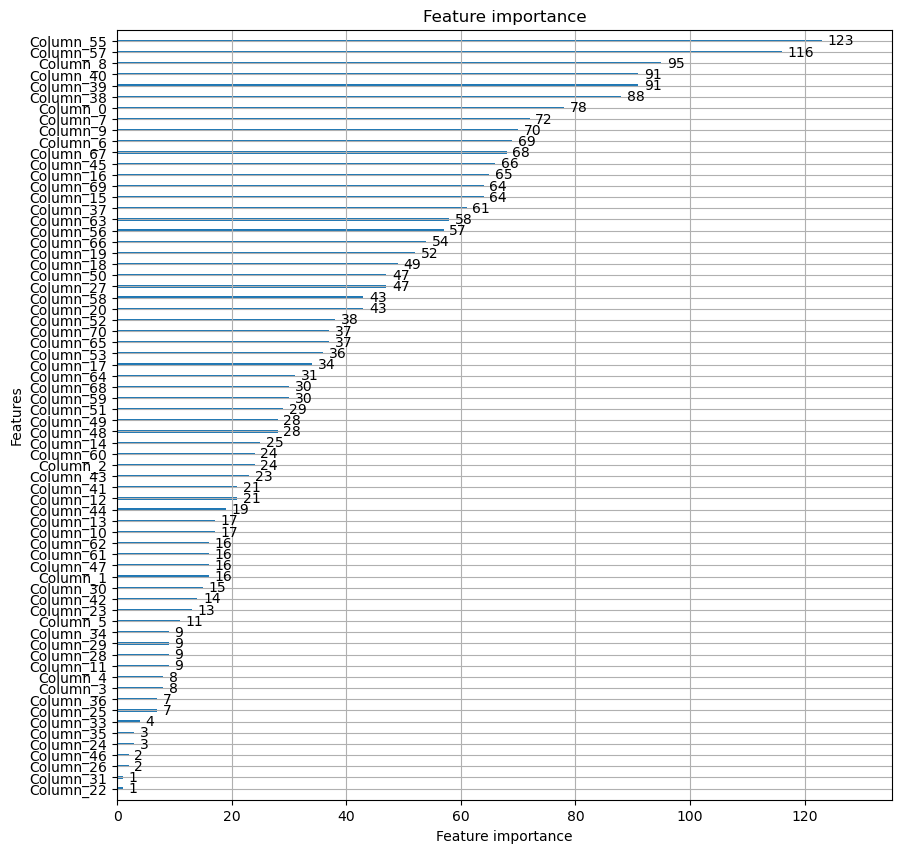

In [14]:
lgbm.plot_importance(lgb,figsize=(10, 10))

In [22]:
lgbm.plot_metric(lgb)

ValueError: eval results cannot be empty.

#### 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [23]:
# テストデータに対する予測値の作成
# pred = lgb.predict_proba(X_test, num_iteration=lgb.best_iteration)[:, 1]
pred = lgb.predict_proba(X_test)[:, 1]

In [24]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

AttributeError: 'MyUtils' object has no attribute 'sample_sub'

In [ ]:
# 提出用のcsvファイルを作成
# formatを指定して現在時刻を取得（yyyyMMddhhmm）

sample_sub.to_csv(f'{output_path}/{time}.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！